In [1]:
import seaborn as sns
import seisbench.data as sbd
import seisbench.generate as sbg
import numpy as np
import matplotlib.pyplot as plt
from seisbench.util import worker_seeding
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import einops
import tqdm
from collections import defaultdict
from seisLM.model.foundation.pretrained_models import LitMultiDimWav2Vec2, MultiDimWav2Vec2ForPreTraining

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = sbd.ETHZ(sampling_rate=100)
train, dev, test = data.train_dev_test()
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

print(len(phase_dict))
ADD_NOISE_LABEL = True #False
# ADD_NOISE_LABEL = False



2024-08-25 23:04:24,310 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2024-08-25 23:04:24,592 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


15


In [3]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

augmentations = [
    sbg.WindowAroundSample(
      list(phase_dict.keys()),
      samples_before=3000,
      windowlen=6000,
      selection="random",
      strategy="variable"
    ),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="std"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(
      label_columns=phase_dict, sigma=30, dim=0, noise_column=ADD_NOISE_LABEL
    )
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

(3, 3001)


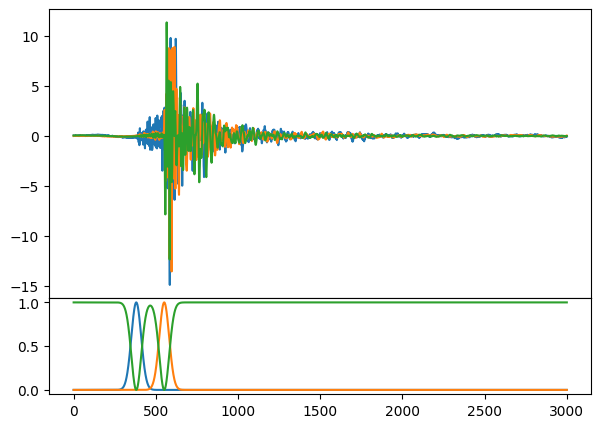

In [4]:
sample = train_generator[np.random.randint(len(train_generator))]
print(sample['y'].shape)
fig = plt.figure(figsize=(7, 5))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T);
axs[1].plot(sample["y"].T);

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LitMultiDimWav2Vec2.load_from_checkpoint(
  '/home/liu0003/Desktop/projects/seisLM/results/models/pretrained_seisLM/pretrain_config_layernorm_std_small_batch_6_datasets_42__2024-08-14-09h-06m-17s/checkpoints/epoch=33-step=893792.ckpt',
).model

USE_RANDOM_INIT = False #True

if USE_RANDOM_INIT:
  model = MultiDimWav2Vec2ForPreTraining(model.config)

model = model.to(device)
model = model.eval()

In [6]:
batch_size = 8
num_workers = 4  # The number of threads used for loading data

train_loader = DataLoader(
  train_generator,
  batch_size=batch_size,
  shuffle=True,
  num_workers=num_workers,
  worker_init_fn=worker_seeding
)

In [7]:

num_phasepick_labels = len(np.unique(list(phase_dict.values())))

if ADD_NOISE_LABEL:
  num_phasepick_labels += 1

cooccurence_dict = defaultdict(
  lambda: np.zeros(num_phasepick_labels))

num_coocurrence_timesteps = 0

progress_bar = tqdm.tqdm(train_loader)

for batch in progress_bar:

  with torch.no_grad():
    output = model.wav2vec2(
      input_values=batch["X"].to(device),
      attention_mask=None,
      output_attentions=False,
      output_hidden_states=False,
    )


    extract_features = output.extract_features
    _, _, codevector_indices = model.quantizer(
      extract_features, mask_time_indices=None,
      return_selected_codevector_indices=True
    )

  # [batch, hidden_length, num_groups]
  codevector_indices = codevector_indices.cpu()


  # interpolate the target to the length of the hidden states
  _, hidden_length, _ = extract_features.shape

  # [batch, 16 (number of labels), hidden_length]
  interpolated_target = F.interpolate(
    batch['y'],
    size=hidden_length,
    mode='linear',
    align_corners=True
  )


  batch_aggregated_codevector_indices = einops.rearrange(
    codevector_indices, 'b l g -> (b l) g'
  )

  batch_aggregated_target = einops.rearrange(
    interpolated_target, 'b d l -> (b l) d'
  )


  # Vectorized computation of non-zero target positions
  non_zero_mask = batch_aggregated_target > 0.5  # [batch * hidden_length, num_labels]
  non_zero_indices = np.nonzero(non_zero_mask)  # (indices of non-zero elements)

  # Reshape codevector indices to match target positions
  # [batch * hidden_length, num_groups] -> [batch * hidden_length, 1, num_groups]
  reshaped_codevector_indices = batch_aggregated_codevector_indices[:, np.newaxis, :]

  # Get the corresponding codevector indices and labels
  for nonzero_idx in non_zero_indices:
      seq_idx, label_idx = nonzero_idx
      code_vector_idx = tuple(batch_aggregated_codevector_indices[seq_idx].tolist())
      cooccurence_dict[code_vector_idx][label_idx] += 1

  num_coocurrence_timesteps += non_zero_indices.shape[0]

  # Calculate the ratio
  ratio = len(cooccurence_dict.keys()) / model.config.num_codevectors_per_group ** 2

  # Update the tqdm progress bar with the ratio
  progress_bar.set_postfix(ratio=f'{ratio:.4f}')

100%|██████████| 2829/2829 [04:18<00:00, 10.94it/s, ratio=0.2558]


In [8]:
co_occurrence_matrix = np.stack(
  list(cooccurence_dict.values())
).T

co_occurrence_matrix = co_occurrence_matrix / co_occurrence_matrix.sum(0, keepdims=True)

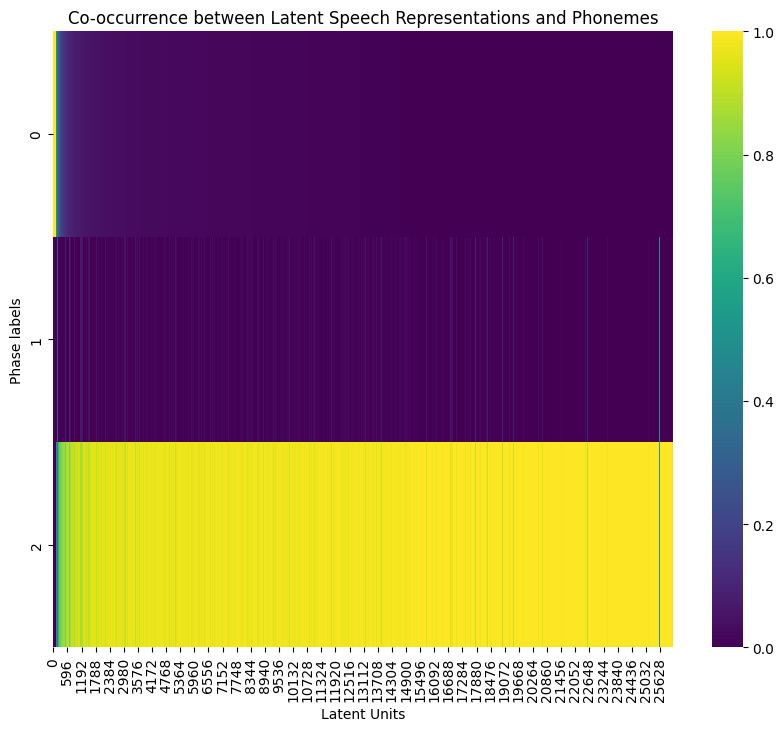

In [15]:
sorted_col_indices = np.argsort(- co_occurrence_matrix[0])
ordered_matrix = co_occurrence_matrix[:, sorted_col_indices]#[:, :1000]

plt.figure(figsize=(10, 8))
sns.heatmap(ordered_matrix, cmap='viridis' )#, xticklabels=ordered_indices, yticklabels=ordered_indices)
plt.ylabel('Phase labels')
plt.xlabel('Latent Units')
plt.title('Co-occurrence between Latent Speech Representations and Phonemes')
plt.show()


In [10]:
ordered_matrix

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])